In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

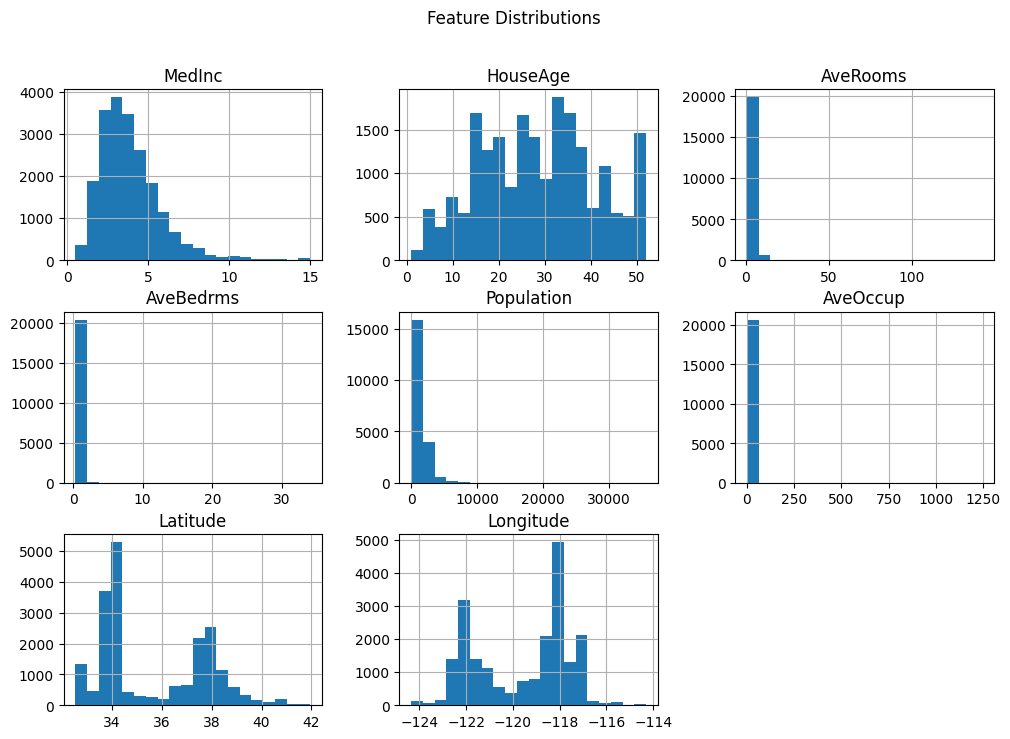

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

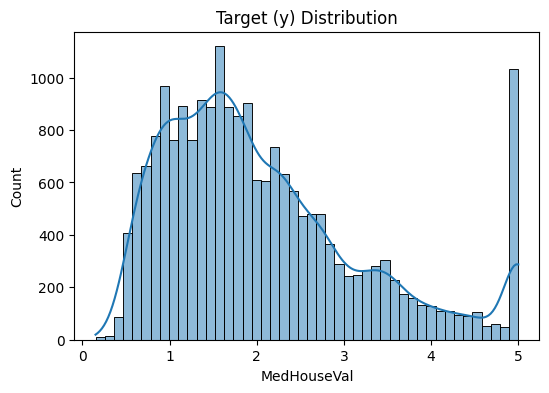

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

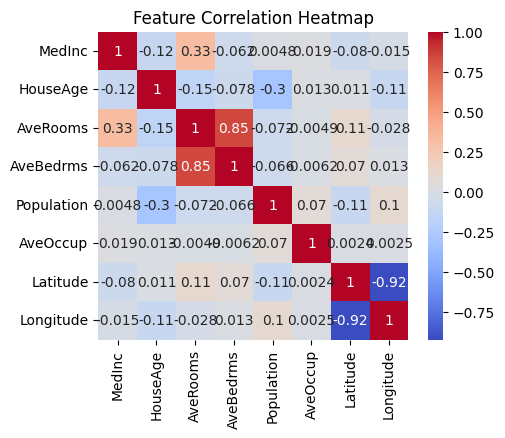

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [9]:
import comparison
import pandas as pd

proposal_probs_mtmh={"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
proposal_probs_default={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, 
                                            proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default,
                                            n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix (all 4):")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix (all 4):
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.527684                 1.652056             1.753880   
1                  1.729970                 1.542657             1.681668   
2                  1.410167                 1.524938             2.018415   
3                  1.478299                 1.714037             1.578198   
4                  1.512980                 1.882803             1.525308   
5                  1.605562                 1.644159             1.766935   
6                  1.676194                 1.469977             1.251450   
7                  1.540749                 1.474149             1.491922   
8                  1.841484                 1.995330             1.516125   
9                  1.437233                 1.562342             1.173987   
mean               1.576032                 1.646245             1.575789   
std                0.137013      

In [10]:
rhat_df.to_csv("results4/real3_CalHousing_rhat.csv", index=False)

In [11]:
proposal_probs_mtmh={"multi_grow": 0.5, "multi_prune": 0.5}
proposal_probs_default={"grow": 0.5, "prune": 0.5}
rhat_df2 = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, 
                                            proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default,
                                            n_jobs=-2)
mean_row = pd.DataFrame([rhat_df2.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df2.std()], index=["std"])
rhat_df2_with_stats = pd.concat([rhat_df2, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix (only 2):")
print(rhat_df2_with_stats)

Gelman-Rubin R̂ comparison matrix (only 2):
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.565706                 1.519138             2.180574   
1                  1.514844                 1.903019             2.212667   
2                  1.419106                 1.595234             1.929127   
3                  1.731000                 1.553701             1.787961   
4                  1.420992                 1.883699             1.825161   
5                  1.311093                 1.468731             1.906411   
6                  1.418589                 1.341016             1.770619   
7                  2.028904                 1.469382             2.370114   
8                  1.549591                 1.480054             1.784675   
9                  1.390627                 1.707016             1.782828   
mean               1.535045                 1.592099             1.955014   
std                0.209464     

In [12]:
rhat_df2.to_csv("results2/real3_CalHousing_rhat.csv", index=False)

In [13]:
# Create comparison table with means and standard deviations in parentheses
comparison_table = pd.DataFrame(index=['All 4 Operations', 'Grow/Prune Only'])

# Calculate mean and standard deviation for each column
for col in rhat_df.columns:
    # First row: All 4 operations (grow/prune/change/swap)
    mean_4ops = rhat_df[col].mean()
    std_4ops = rhat_df[col].std()
    comparison_table.loc['All 4 Operations', col] = f"{mean_4ops:.4f} ({std_4ops:.4f})"
    
    # Second row: Only grow/prune operations
    mean_2ops = rhat_df2[col].mean()
    std_2ops = rhat_df2[col].std()
    comparison_table.loc['Grow/Prune Only', col] = f"{mean_2ops:.4f} ({std_2ops:.4f})"

print("Gelman-Rubin R̂ Comparison Table:")
print(comparison_table)

Gelman-Rubin R̂ Comparison Table:
                 MultiBART_Rhat_Sigma2 DefaultBART_Rhat_Sigma2  \
All 4 Operations       1.5760 (0.1370)         1.6462 (0.1750)   
Grow/Prune Only        1.5350 (0.2095)         1.5921 (0.1849)   

                 MultiBART_Rhat_RMSE DefaultBART_Rhat_RMSE  
All 4 Operations     1.5758 (0.2484)       1.8064 (0.2573)  
Grow/Prune Only      1.9550 (0.2186)       1.9201 (0.2052)  


In [14]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

proposal_probs_mtmh={"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
proposal_probs_default={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5,
                                             proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

test_mse:
      bart_mtmh      bart
0      0.210202  0.220808
1      0.222350  0.227810
2      0.224496  0.233558
3      0.204164  0.211569
4      0.216044  0.228576
5      0.219813  0.221952
6      0.217108  0.228216
7      0.220715  0.224067
8      0.218733  0.233533
9      0.213808  0.221989
mean   0.216743  0.225208
std    0.006064  0.006615

pi_length:
      bart_mtmh      bart
0      1.568114  1.707358
1      1.586130  1.691926
2      1.572448  1.693551
3      1.596266  1.703181
4      1.579642  1.710936
5      1.556151  1.682897
6      1.593689  1.710267
7      1.548164  1.695076
8      1.572103  1.690308
9      1.557215  1.688216
mean   1.572992  1.697372
std    0.016196  0.009869

coverage:
      bart_mtmh      bart
0      0.925581  0.931395
1      0.928682  0.934690
2      0.923450  0.931008
3      0.932364  0.934690
4      0.928295  0.936434
5      0.918217  0.931395
6      0.928488  0.933333
7      0.918798  0.930620
8      0.921705  0.928682
9      0.924225  0.931202
mean 

In [15]:
for k, v in mse_results.items():
    csv_name = f"results4/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

In [16]:
proposal_probs_mtmh={"multi_grow": 0.5, "multi_prune": 0.5}
proposal_probs_default={"grow": 0.5, "prune": 0.5}
mse_results2 = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5,
                                             proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default)
for k, v in mse_results2.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

test_mse:
      bart_mtmh      bart
0      0.214970  0.225751
1      0.221622  0.228650
2      0.228500  0.234752
3      0.207516  0.215160
4      0.220724  0.227203
5      0.222022  0.223965
6      0.220067  0.231588
7      0.227569  0.236211
8      0.217241  0.227427
9      0.215268  0.228360
mean   0.219550  0.227907
std    0.006200  0.005902

pi_length:
      bart_mtmh      bart
0      1.640816  1.708316
1      1.630090  1.726727
2      1.647707  1.708006
3      1.631080  1.725071
4      1.616733  1.706961
5      1.624981  1.682865
6      1.644548  1.721395
7      1.619848  1.687001
8      1.637150  1.697834
9      1.630583  1.707356
mean   1.632354  1.707153
std    0.010240  0.014877

coverage:
      bart_mtmh      bart
0      0.931977  0.929457
1      0.926938  0.937791
2      0.929457  0.932752
3      0.933915  0.936434
4      0.930233  0.935271
5      0.926938  0.931977
6      0.932364  0.932364
7      0.921705  0.926550
8      0.929070  0.934302
9      0.925969  0.929845
mean 

In [17]:
for k, v in mse_results2.items():
    csv_name = f"results2/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

In [18]:
# Create comparison tables for all MSE results metrics
for metric_name, metric_df in mse_results.items():
    print(f"\n{metric_name.upper()} Comparison Table:")
    print("=" * 50)
    
    # Create comparison table for this metric
    comparison_table = pd.DataFrame(index=['All 4 Operations', 'Grow/Prune Only'])
    
    # Calculate mean and standard deviation for each column
    for col in metric_df.columns:
        # First row: All 4 operations (grow/prune/change/swap)
        mean_4ops = metric_df[col].mean()
        std_4ops = metric_df[col].std()
        comparison_table.loc['All 4 Operations', col] = f"{mean_4ops:.4f} ({std_4ops:.4f})"
    
    # Get corresponding metric from the 2-operations results
    metric_df2 = mse_results2[metric_name]
    for col in metric_df2.columns:
        # Second row: Only grow/prune operations
        mean_2ops = metric_df2[col].mean()
        std_2ops = metric_df2[col].std()
        comparison_table.loc['Grow/Prune Only', col] = f"{mean_2ops:.4f} ({std_2ops:.4f})"
    
    print(comparison_table)
    print()


TEST_MSE Comparison Table:
                        bart_mtmh             bart
All 4 Operations  0.2167 (0.0061)  0.2252 (0.0066)
Grow/Prune Only   0.2196 (0.0062)  0.2279 (0.0059)


PI_LENGTH Comparison Table:
                        bart_mtmh             bart
All 4 Operations  1.5730 (0.0162)  1.6974 (0.0099)
Grow/Prune Only   1.6324 (0.0102)  1.7072 (0.0149)


COVERAGE Comparison Table:
                        bart_mtmh             bart
All 4 Operations  0.9250 (0.0046)  0.9323 (0.0024)
Grow/Prune Only   0.9289 (0.0036)  0.9327 (0.0034)


TRAIN_TIME Comparison Table:
                           bart_mtmh              bart
All 4 Operations  555.0588 (16.5397)  77.3042 (2.4282)
Grow/Prune Only    322.7886 (4.9607)  69.8271 (2.3447)

